In [1]:
%matplotlib inline

import sys, os
sys.path.insert(0, '../../pytorch-segmentation-detection/vision/')
sys.path.append('../../pytorch-segmentation-detection/')

# Use second GPU -pytorch-segmentation-detection- change if you want to use a first one
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

from PIL import Image
from matplotlib import pyplot as plt

import torch
from torchvision import transforms
from torch.autograd import Variable
import pytorch_segmentation_detection.models.resnet_dilated as resnet_dilated

import numpy as np
import glob

import sys; sys.path.append('../dataset')
sys.path.append('../correspondence_tools')
import correspondence_plotter
from labelfusion import LabelFusionDataset


descriptor_dimensionality = 3
nets = sorted(glob.glob("trained_models/10_drill_long_"+str(descriptor_dimensionality)+"d/dense_resnet*.pth"))
print "Networks:"
for net in nets:
    print "   - ", net

lf = LabelFusionDataset()
scene = "2017-06-13-12"

img_a_index = "0000000001"
img_a_rgb, img_a_depth, img_a_pose = lf.get_specific_rgbd_with_pose(scene, img_a_index)

img_b_index = "0000000300"
img_b_rgb, img_b_depth, img_b_pose = lf.get_specific_rgbd_with_pose(scene, img_b_index)

Networks:
   -  trained_models/10_drill_long_3d/dense_resnet_34_8s_00000.pth
   -  trained_models/10_drill_long_3d/dense_resnet_34_8s_00500.pth
   -  trained_models/10_drill_long_3d/dense_resnet_34_8s_01000.pth
   -  trained_models/10_drill_long_3d/dense_resnet_34_8s_01500.pth
   -  trained_models/10_drill_long_3d/dense_resnet_34_8s_02000.pth
   -  trained_models/10_drill_long_3d/dense_resnet_34_8s_02500.pth
   -  trained_models/10_drill_long_3d/dense_resnet_34_8s_03000.pth
   -  trained_models/10_drill_long_3d/dense_resnet_34_8s_03500.pth
Using LabelFusionDataset with:
   - number of scenes: 5
   - total images:     5189


In [3]:
valid_transform = transforms.Compose(
                [
                     transforms.ToTensor(),
                ])

def forward_on_img(net, img):
    img = valid_transform(img)
    img = img.unsqueeze(0)
    img = Variable(img.cuda())
    fcn = resnet_dilated.Resnet34_8s(num_classes=descriptor_dimensionality)
    fcn.load_state_dict(torch.load(net))
    fcn.cuda()
    fcn.eval()
    res = fcn(img)
    res = res.squeeze(0)
    res = res.permute(1,2,0)
    res = res.data.cpu().numpy().squeeze()
    return res

res_a = forward_on_img(nets[0], img_a_rgb)
res_b = forward_on_img(nets[0], img_b_rgb)

/usr/local/lib/python2.7/dist-packages/torch/nn/modules/module.py:482: UserWarning: src is not broadcastable to dst, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  own_state[name].copy_(param)
/usr/local/lib/python2.7/dist-packages/torch/nn/functional.py:1423: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.upsample instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.upsample instead.")


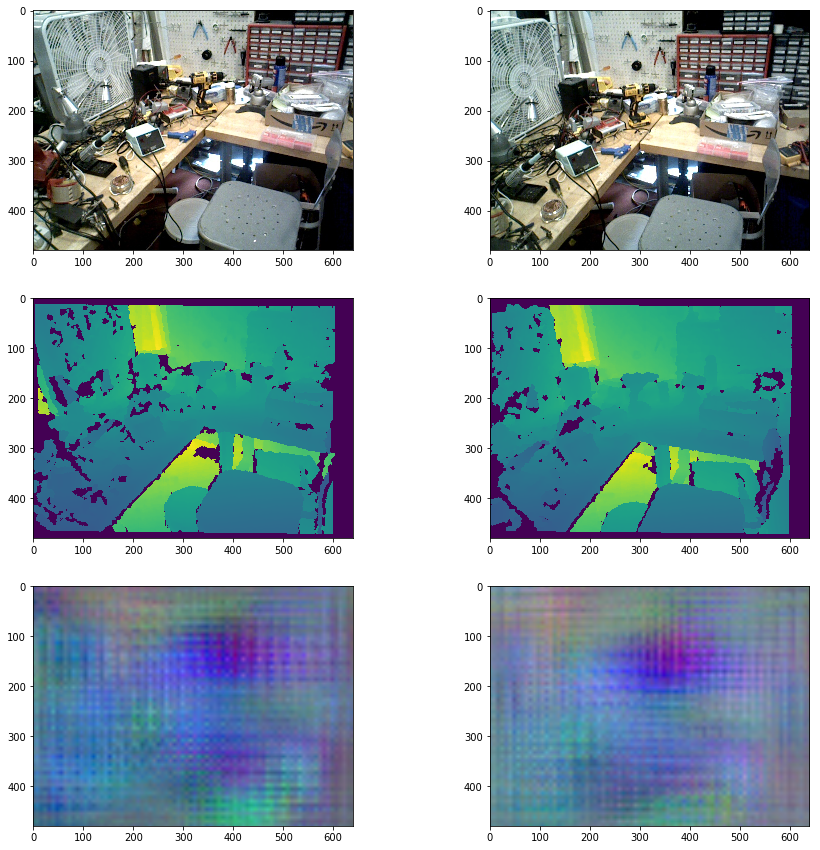

In [4]:
def normalize(res):
    normed_res = res + -np.min(res)
    normed_res = normed_res / np.max(normed_res)
    return normed_res

if (descriptor_dimensionality == 1) or (descriptor_dimensionality == 3):
    fig, axes = plt.subplots(nrows=3, ncols=2)
    fig.set_figheight(15)
    fig.set_figwidth(15)
    axes = axes.flat[0:]
    images = [img_a_rgb, img_b_rgb, img_a_depth, img_b_depth, normalize(res_a), normalize(res_b)]
    for ax, img in zip(axes, images):
        ax.imshow(img)
    plt.show()

## What do final desciprtors look like?

In [5]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

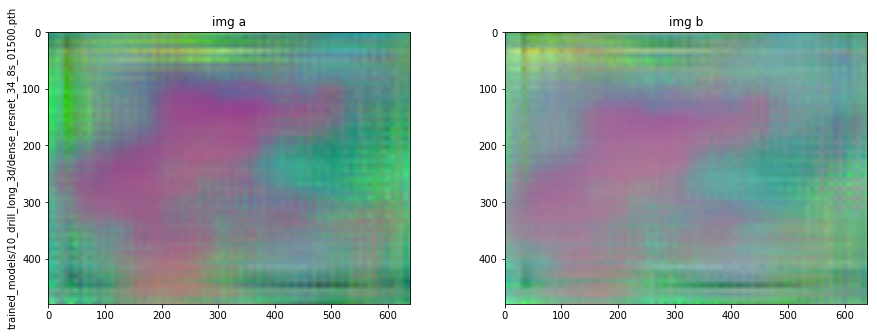

In [6]:
if (descriptor_dimensionality == 1) or (descriptor_dimensionality == 3):
    for index, this_net in enumerate(nets[-1:]):
        fig, axes = plt.subplots(nrows=1, ncols=2)
        fig.set_figheight(5)
        fig.set_figwidth(15)
        if index == 0:
            axes[0].set_title("img a")
            axes[1].set_title("img b")
        axes[0].imshow(normalize(forward_on_img(this_net, img_a_rgb)))
        axes[1].imshow(normalize(forward_on_img(this_net, img_b_rgb)))
        axes[0].set_ylabel(this_net)
        plt.show()

## How about overlaying these images?



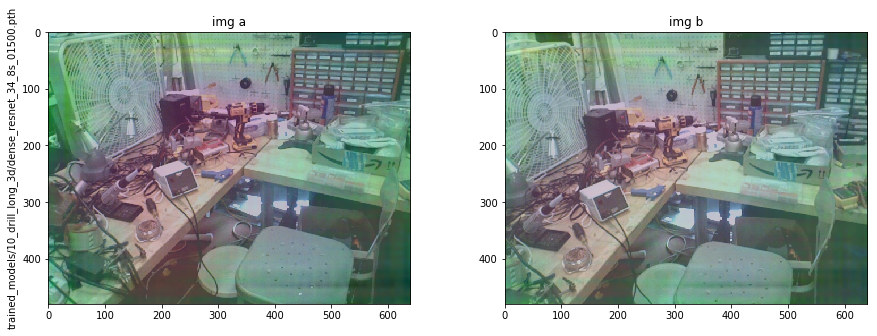

In [7]:
this_net = nets[-1]
if (descriptor_dimensionality == 1) or (descriptor_dimensionality == 3):
    fig, axes = plt.subplots(1, ncols=2)
    fig.set_figheight(5)
    fig.set_figwidth(15)
    axes[0].set_title("img a")
    axes[1].set_title("img b")
    axes[0].imshow(normalize(forward_on_img(this_net, img_a_rgb)))
    axes[0].imshow(img_a_rgb, alpha=0.5)
    axes[1].imshow(normalize(forward_on_img(this_net, img_b_rgb)))
    axes[1].imshow(img_b_rgb, alpha=0.5)
    axes[0].set_ylabel(this_net)
    plt.show()

## What if we use the mask from LabelFusion data?

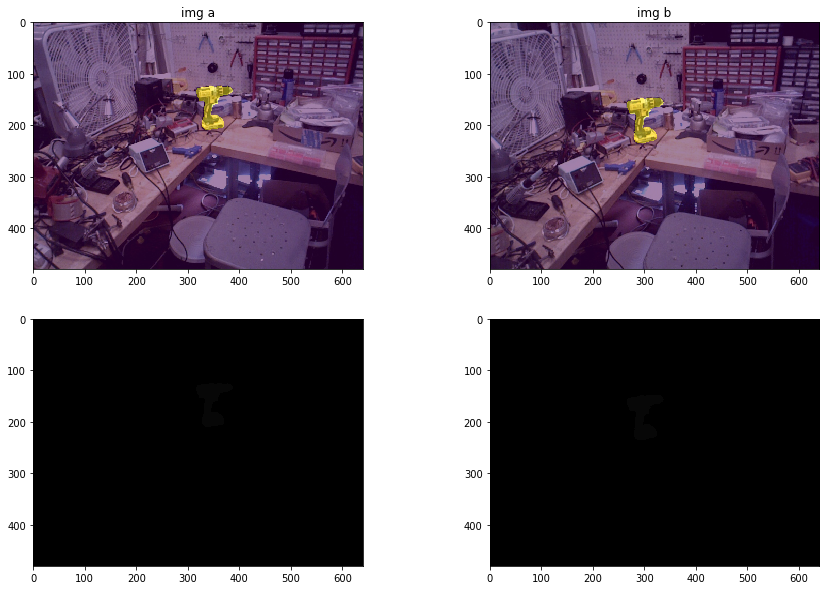

In [11]:
# step 1: plot a mask
scene_dir = lf.get_full_path_for_scene("2017-06-13-12")
images_dir = os.path.join(scene_dir, "images")

mask_a_color_file = images_dir+"/"+img_a_index+"_labels.png"
mask_a_color = Image.open(mask_a_color_file).convert('RGB')
mask_a_file = images_dir+"/"+img_a_index+"_labels.png"
mask_a = np.asarray(Image.open(mask_a_file))


mask_b_color_file = images_dir+"/"+img_b_index+"_labels.png"
mask_b_color = Image.open(mask_b_color_file).convert('RGB')
mask_b_file = images_dir+"/"+img_b_index+"_labels.png"
mask_b = np.asarray(Image.open(mask_b_file))

fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(10)
fig.set_figwidth(15)
axes[0,0].set_title("img a")
axes[0,1].set_title("img b")
axes[0,0].imshow(img_a_rgb)
axes[0,0].imshow(mask_a, alpha=0.5)
axes[0,1].imshow(img_b_rgb)
axes[0,1].imshow(mask_b, alpha=0.5)
axes[1,0].imshow(mask_a_color)
axes[1,1].imshow(mask_b_color)
plt.show()


## What if we mask the dense descriptor representation for the drill?

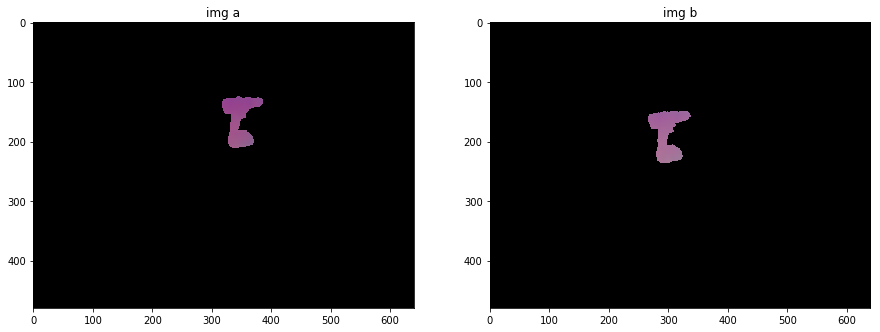

In [12]:
res_a = forward_on_img(this_net, img_a_rgb)
res_b = forward_on_img(this_net, img_b_rgb)

mask_a_3_channel = np.zeros((480,640,3))
mask_a_3_channel[:,:,0] = mask_a_3_channel[:,:,1] = mask_a_3_channel[:,:,2] = mask_a/np.max(mask_a)
mask_b_3_channel = np.zeros((480,640,3))
mask_b_3_channel[:,:,0] = mask_b_3_channel[:,:,1] = mask_b_3_channel[:,:,2] = mask_b/np.max(mask_a)

masked_res_a = mask_a_3_channel*normalize(res_a)
masked_res_b = mask_b_3_channel*normalize(res_b)

fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_figheight(10)
fig.set_figwidth(15)
axes[0].set_title("img a")
axes[1].set_title("img b")
axes[0].imshow(masked_res_a)
axes[1].imshow(masked_res_b)
plt.show()

## What if we multiply each pixel by some scalar?

Note: this will implicitly cast each float to a uint8, and we'll get some psuedo-normalization with wrapping to help differentiate different colors better. See: 
https://stackoverflow.com/questions/39925420/bizzare-matplotlib-behaviour-in-displaying-images-cast-as-floats

In [ ]:
res_a = forward_on_img(this_net, img_a_rgb)
res_b = forward_on_img(this_net, img_b_rgb)

mask_a_3_channel = np.zeros((480,640,3))
mask_a_3_channel[:,:,0] = mask_a_3_channel[:,:,1] = mask_a_3_channel[:,:,2] = mask_a/np.max(mask_a)
mask_b_3_channel = np.zeros((480,640,3))
mask_b_3_channel[:,:,0] = mask_b_3_channel[:,:,1] = mask_b_3_channel[:,:,2] = mask_b/np.max(mask_a)

normalized_masked_res_a = normalize(mask_a_3_channel*res_a)
normalized_masked_res_b = normalize(mask_b_3_channel*res_b)

scale = 6

masked_res_a = mask_a_3_channel*normalized_masked_res_a*scale
masked_res_b = mask_b_3_channel*normalized_masked_res_b*scale

print np.max(masked_res_a)
#print masked_res_a[135:145,340:350]

fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_figheight(10)
fig.set_figwidth(15)
axes[0].set_title("img a")
axes[1].set_title("img b")
axes[0].imshow(masked_res_a)
axes[1].imshow(masked_res_b)
plt.show()